In [54]:
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas_datareader as pdd
from datetime import datetime
from meteostat import Stations, Daily

In [2]:
dr = pd.read_csv('results_group_h.csv', sep = ',', usecols = [0, 1, 2, 3], index_col = 'Trajectory')

In [3]:
s = len(dr.groupby(dr.index))
print(s)

df = dr.groupby(dr.index).filter(lambda x: len(x) >= 50)
df = df.assign(Δx = df.groupby(df.index)['x'].diff().values)
df = df.assign(Δy = df.groupby(df.index)['y'].diff().values)
df = df.dropna()
df

9200


,Frame,x,y,Δx,Δy
Trajectory,,,,,
1,1,175.268,90.580,2.106,0.743
1,2,171.117,90.103,-4.151,-0.477
1,3,171.117,90.103,0.000,0.000
1,4,171.127,88.631,0.010,-1.472
1,5,172.421,90.157,1.294,1.526
...,...,...,...,...,...
8862,1832,33.347,224.850,-0.162,-0.181
8862,1833,33.622,225.149,0.275,0.299
8862,1834,33.521,225.182,-0.101,0.033


In [4]:
kc = 4 #kurtosis cutoff

dfk = df.groupby(df.index).filter(lambda x: (x['Δx'].kurtosis() + 3) <= kc and (x['Δy'].kurtosis() + 3) <= kc)
print(dfk)
e = len(dfk.groupby(dfk.index))
print('Number of used trajectories: ' + str(e))

Δs = s - e
print('Difference in number of trajectories: ' + str(Δs))

            Frame        x        y     Δx     Δy
Trajectory                                       
1               1  175.268   90.580  2.106  0.743
1               2  171.117   90.103 -4.151 -0.477
1               3  171.117   90.103  0.000  0.000
1               4  171.127   88.631  0.010 -1.472
1               5  172.421   90.157  1.294  1.526
...           ...      ...      ...    ...    ...
8858         1840  430.178  122.234  0.700  1.485
8858         1841  433.748  122.983  3.570  0.749
8858         1842  437.941  120.703  4.193 -2.280
8858         1843  435.376  117.457 -2.565 -3.246
8858         1844  435.583  114.592  0.207 -2.865

[18599 rows x 5 columns]
Number of used trajectories: 210
Difference in number of trajectories: 8990


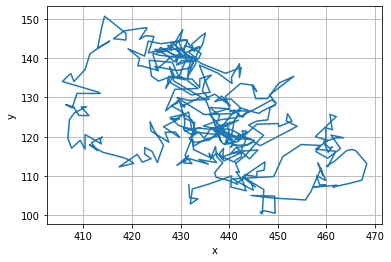

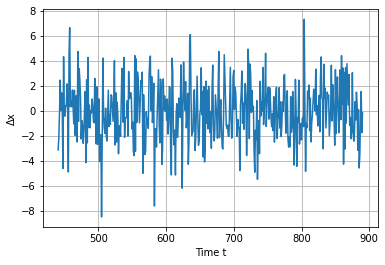

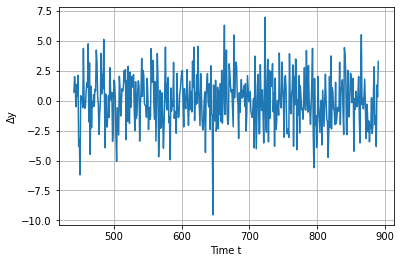

In [5]:
max_traj = dfk.groupby(dfk.index).count()['Frame'].max()
df_max = dfk.groupby(dfk.index).filter(lambda x: len(x) == max_traj)

df_max.plot(x = 'x', y = 'y', legend = False)
plt.grid(True) ; plt.xlabel('x') ; plt.ylabel('y')
plt.show()

df_max.plot(x = 'Frame', y = 'Δx', legend = False)
plt.grid(True) ; plt.xlabel('Time t') ; plt.ylabel('Δx')
plt.show()

df_max.plot(x = 'Frame', y = 'Δy', legend = False)
plt.grid(True) ; plt.xlabel('Time t') ; plt.ylabel('Δy')
plt.show()

In [6]:
mean_x = dfk.groupby(dfk.index)['Δx'].mean().mean()
mean_y = dfk.groupby(dfk.index)['Δy'].mean().mean()
var_x = dfk.groupby(dfk.index)['Δx'].var().var()
var_y = dfk.groupby(dfk.index)['Δy'].var().var()
skew_x = dfk.groupby(dfk.index)['Δx'].skew().skew()
skew_y = dfk.groupby(dfk.index)['Δy'].skew().skew()
kurt_x = dfk.groupby(dfk.index)['Δx'].apply(lambda x: sps.kurtosis(x, fisher = False)).apply(lambda x: sps.kurtosis(x, fisher = False))
kurt_y = dfk.groupby(dfk.index)['Δy'].apply(lambda x: sps.kurtosis(x, fisher = False)).apply(lambda x: sps.kurtosis(x, fisher = False))

In [7]:
dfk = dfk.assign(Δx_n = dfk.groupby(dfk.index)['Δx'].apply(lambda x: (x - np.mean(x)) / np.std(x)))
dfk = dfk.assign(Δy_n = dfk.groupby(dfk.index)['Δy'].apply(lambda x: (x - np.mean(x)) / np.std(x)))
dfk

,Frame,x,y,Δx,Δy,Δx_n,Δy_n
Trajectory,,,,,,,
1,1,175.268,90.580,2.106,0.743,0.879191,0.382696
1,2,171.117,90.103,-4.151,-0.477,-1.306811,-0.200088
1,3,171.117,90.103,0.000,0.000,0.143420,0.027771
1,4,171.127,88.631,0.010,-1.472,0.146914,-0.675391
1,5,172.421,90.157,1.294,1.526,0.595503,0.756728
...,...,...,...,...,...,...,...
8858,1840,430.178,122.234,0.700,1.485,0.335296,0.493484
8858,1841,433.748,122.983,3.570,0.749,1.535379,0.212854
8858,1842,437.941,120.703,4.193,-2.280,1.795885,-0.942076


In [8]:
cmean_x = dfk['Δx_n'].mean()
cmean_y = dfk['Δy_n'].mean()
cvar_x = dfk['Δx_n'].var()
cvar_y = dfk['Δy_n'].var()
cskew_x = dfk['Δx_n'].skew()
cskew_y = dfk['Δy_n'].skew()
ckurt_x = dfk['Δx_n'].kurtosis() + 3
ckurt_y = dfk['Δy_n'].kurtosis() + 3
                          
print(cmean_x, cmean_y, cvar_x, cvar_y, cskew_x, cskew_y, ckurt_x, ckurt_y)

1.3475608785909408e-18 8.356966688936067e-19 1.000053769222502 1.0000537692225007 0.013393456218578277 -0.030451237451740897 2.93997829346952 3.0095933204921286


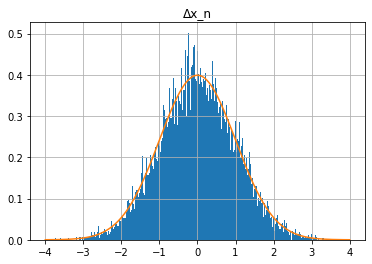

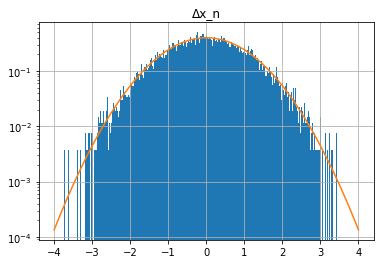

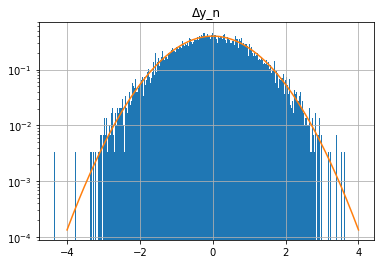

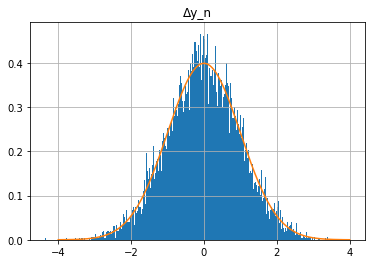

In [9]:
dfk.hist(column = 'Δx_n', density = True, bins = 500)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
plt.show()

dfk.hist(column = 'Δx_n', density = True, log = True, bins = 500)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
plt.semilogy()
plt.show()

dfk.hist(column = 'Δy_n', density = True, log = True, bins = 500)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
plt.semilogy()
plt.show()

dfk.hist(column = 'Δy_n', density = True, bins = 500)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))

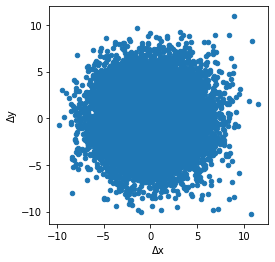

In [10]:
ax = dfk.plot(kind = 'scatter', x = 'Δx', y = 'Δy')
ax.set_aspect('equal')

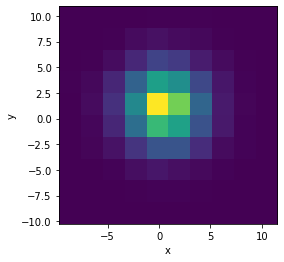

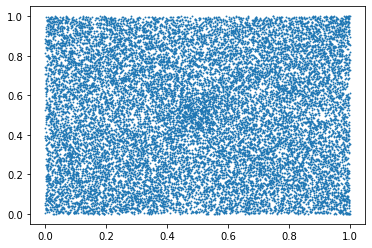

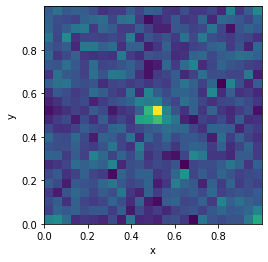

In [11]:
def qrank(series):
    return (series.argsort().argsort() - 0.5) / len(series)

heatmap, xedges, yedges = np.histogram2d(dfk['Δx'], dfk['Δy'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()

x_r = qrank(dfk['Δx'])
y_r = qrank(dfk['Δy'])

plt.scatter(x_r, y_r, s = 0.75)
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_r, y_r, bins=(24, 24))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()

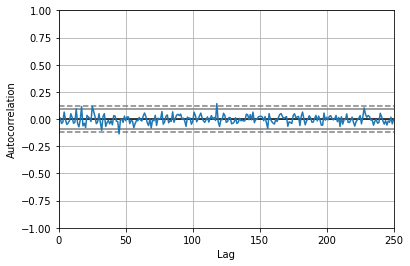

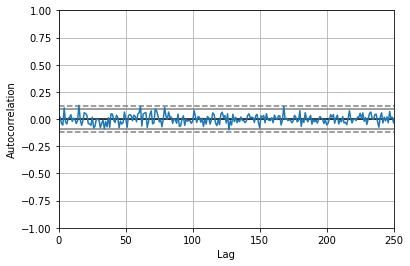

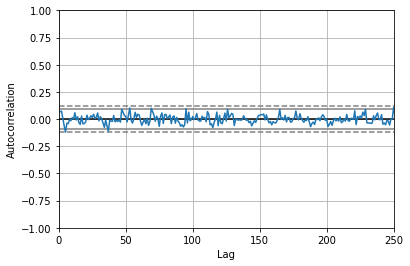

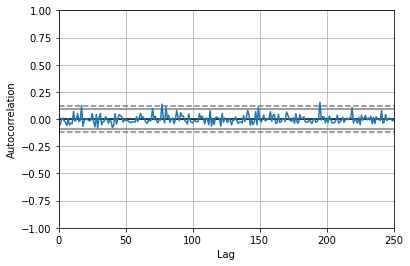

In [12]:
x = pd.plotting.autocorrelation_plot(df_max['Δx']) 
x.plot
plt.axis([0, 250, -1, 1])
plt.show()

y = pd.plotting.autocorrelation_plot(df_max['Δy']) 
plt.axis([0, 250, -1, 1])
y.plot
plt.show()

x2 = pd.plotting.autocorrelation_plot(df_max['Δx'].apply(lambda x: x ** 2)) 
x2.plot
plt.axis([0, 250, -1, 1])
plt.show()

y2 = pd.plotting.autocorrelation_plot(df_max['Δy'].apply(lambda x: x ** 2)) 
y2.plot
plt.axis([0, 250, -1, 1])
plt.show()

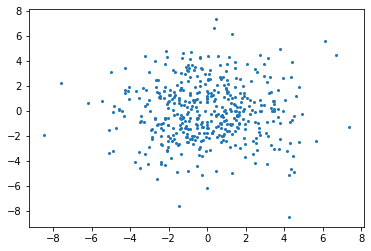

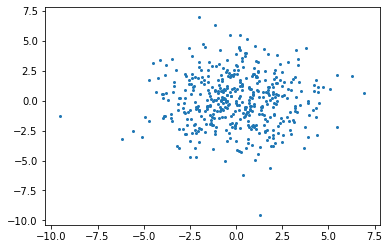

In [13]:
x1 = df_max['Δx'][1:]
x2 = df_max['Δx'][:-1]

plt.scatter(x1, x2, s = 4)

plt.show()

y1 = df_max['Δy'][1:]
y2 = df_max['Δy'][:-1]

plt.scatter(y1, y2, s = 4)

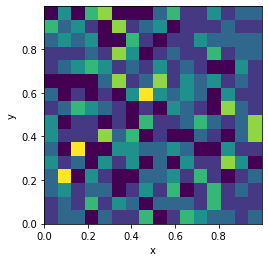

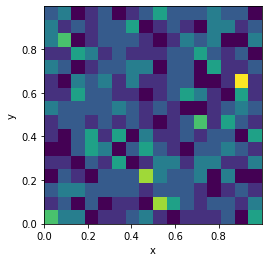

In [14]:
y1_r = qrank(y1)
y2_r = qrank(y2)

heatmap, xedges, yedges = np.histogram2d(y1_r, y2_r, bins=(16, 16))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()

x1_r = qrank(x1)
x2_r = qrank(x2)

heatmap, xedges, yedges = np.histogram2d(x1_r, x2_r, bins=(16, 16))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()

In [15]:
shares = ['PFE', 'GME', 'AMZN', 'AZN', 'DDAIF', 'TSLA', 'TYEKF', 'VWDRY', 'DGV2.F', 'RWEOY']   
#Pfizer, GameStop, Amazon, Astrazeneca, Mercedes, Tesla, Thyssenkrupp, Vestas Wind Systems, ABACUS MNG (Kohle), RWE

yf.pdr_override()
raw_data = pdd.get_data_yahoo(shares, start = '2011-02-11', end = '2021-02-11')
data = raw_data['Adj Close']
data

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-11,12.371558,13.654530,189.250000,16.028015,56.820793,4.650000,40.172020,9.560765,0.959998,48.115273
2011-02-14,12.516098,13.378474,190.419998,15.994948,56.584332,4.616000,40.026123,9.588110,0.977998,47.619099
2011-02-15,12.516098,13.492932,189.029999,16.150364,55.786331,4.568000,40.026123,9.569880,1.001997,47.056774
2011-02-16,12.667210,13.647796,186.619995,16.259491,53.909554,4.946000,40.026123,9.533423,1.067997,46.739227
2011-02-17,12.726344,13.540066,187.759995,16.276028,53.362766,4.720000,39.734314,9.396710,1.061997,46.937695
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,34.919998,63.770000,3352.149902,49.730000,80.629997,852.229980,11.650000,72.260002,0.063500,43.799999
2021-02-08,34.820000,60.000000,3322.939941,50.060001,80.250000,863.419983,12.060000,71.190002,0.060000,42.299999
2021-02-09,34.970001,50.310001,3305.000000,50.410000,79.690002,849.460022,11.950000,69.559998,0.070000,41.310001


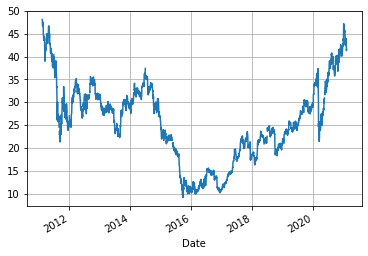

In [16]:
data['RWEOY'].plot()
plt.grid(True)

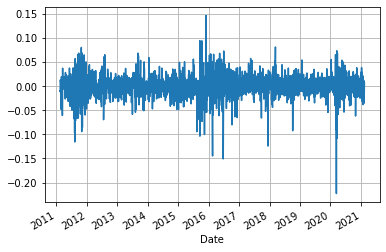

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-14,0.011548,-0.020634,0.006144,-0.002067,-0.004179,-0.007366,-0.003645,0.002852,0.018405,-0.010420
2011-02-15,0.000000,0.008483,-0.007353,0.009623,-0.014305,-0.010508,0.000000,-0.001905,0.023951,-0.011950
2011-02-16,0.011929,0.011347,-0.012914,0.006712,-0.034813,0.076425,0.000000,-0.003824,0.061798,-0.006794
2011-02-17,0.004647,-0.007956,0.006072,0.001016,-0.010247,-0.047881,-0.007344,-0.014549,-0.005650,0.004228
2011-02-18,-0.009380,-0.008020,-0.006756,0.003240,-0.004032,-0.018119,0.000000,-0.002918,0.027473,0.012526
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,0.000859,0.161048,0.006309,-0.012668,0.022200,0.002628,0.000000,0.002214,-0.047244,0.010959
2021-02-08,-0.002872,-0.062833,-0.008790,0.006592,-0.004735,0.012960,0.033997,-0.015030,-0.058333,-0.035461
2021-02-09,0.004289,-0.192606,-0.005428,0.006943,-0.007027,-0.016434,-0.009205,-0.023433,0.142857,-0.023965


In [17]:
R = data.diff().div(data).dropna()
R['RWEOY'].plot()
plt.grid(True)
plt.show()
R

In [18]:
for share in shares:
    print(share + ' Mean: ' + str(R[share].mean()))
    print(share + ' Var: ' + str(R[share].var()))
    print(share + ' Skew: ' + str(R[share].skew()))
    print(share + ' Kurt: ' + str(R[share].kurtosis() + 3))

R_k = R.sub(R.mean()).divide(R.std())
R_k

PFE Mean: 0.0003040279230201803
PFE Var: 0.00016609264822918353
PFE Skew: -0.2327013639982303
PFE Kurt: 8.78896505325553
GME Mean: -0.001315818312822327
GME Var: 0.0032807439432269393
GME Skew: -9.253615420799807
GME Kurt: 242.72727286003584
AMZN Mean: 0.0007925177716737767
AMZN Var: 0.0003856334621420054
AMZN Skew: -0.11181459785292445
AMZN Kurt: 10.180490007158804
AZN Mean: 0.00027972279901251066
AZN Var: 0.00022980546038681228
AZN Skew: -0.993045245971239
AZN Kurt: 19.469047396872185
DDAIF Mean: -0.00011693603541019606
DDAIF Var: 0.00046713520561030757
DDAIF Skew: -0.7810424193545954
DDAIF Kurt: 16.431685007238407
TSLA Mean: 0.0011044674778250094
TSLA Var: 0.0011591157009816124
TSLA Skew: -0.367915029060005
TSLA Kurt: 9.299626571703039
TYEKF Mean: -0.0007352511078225529
TYEKF Var: 0.0009382419867795939
TYEKF Skew: -0.9633020566704688
TYEKF Kurt: 21.318665030737613
VWDRY Mean: -0.00010179844091943806
VWDRY Var: 0.0009088916467629653
VWDRY Skew: -0.7939357309947047
VWDRY Kurt: 13.3714

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-14,0.872482,-0.337277,0.272528,-0.154825,-0.187939,-0.248787,-0.094996,0.097975,0.211783,-0.426444
2011-02-15,-0.023591,0.171072,-0.414810,0.616341,-0.656431,-0.341082,0.024004,-0.059811,0.254408,-0.491713
2011-02-16,0.902048,0.221080,-0.697973,0.424284,-1.605331,2.212343,0.024004,-0.123466,0.545278,-0.271803
2011-02-17,0.336956,-0.115936,0.268825,0.048570,-0.468677,-1.438824,-0.215756,-0.479213,0.026912,0.198323
2011-02-18,-0.751407,-0.117050,-0.384392,0.195279,-0.181124,-0.564635,0.024004,-0.093420,0.281472,0.552243
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,0.043068,2.834665,0.280933,-0.854137,1.032564,0.044761,0.024004,0.076824,-0.292760,0.485397
2021-02-08,-0.246429,-1.074021,-0.487989,0.416404,-0.213675,0.348226,1.133894,-0.495173,-0.377986,-1.494511
2021-02-09,0.309241,-3.339689,-0.316773,0.439552,-0.319723,-0.515141,-0.276514,-0.773896,1.168255,-1.004186


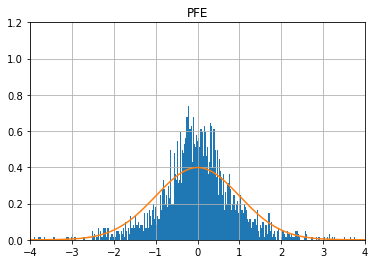

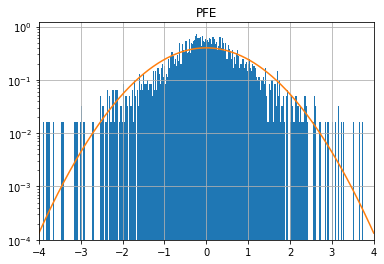

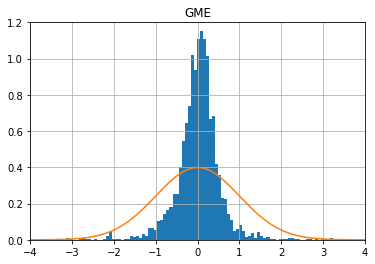

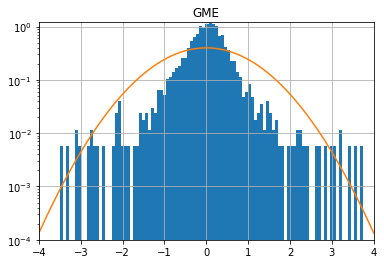

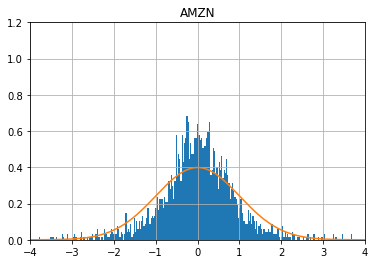

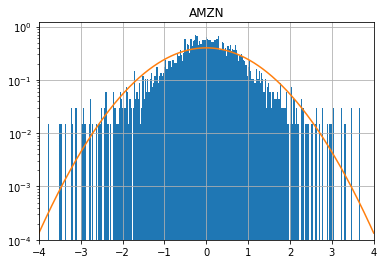

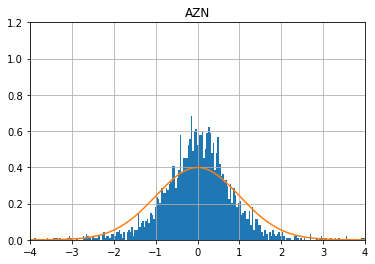

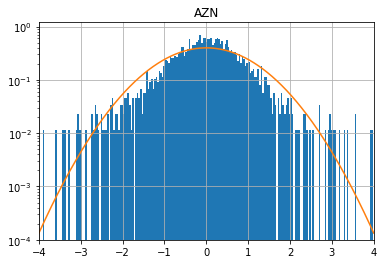

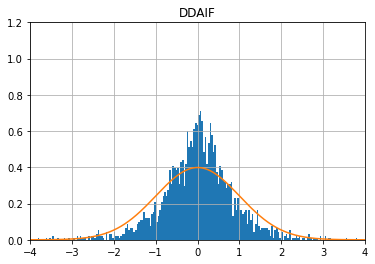

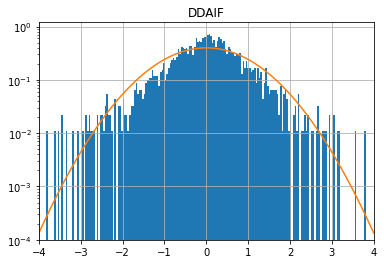

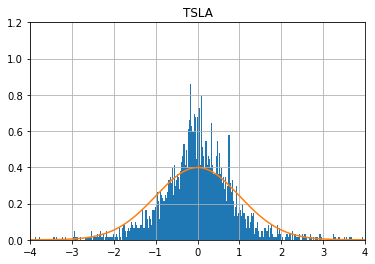

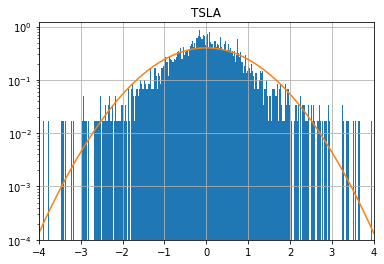

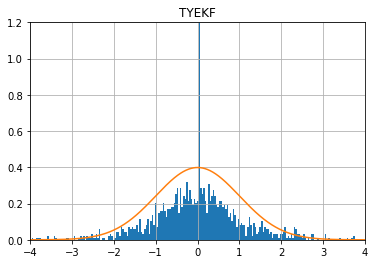

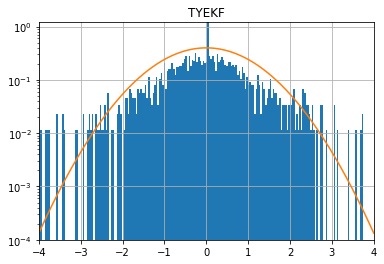

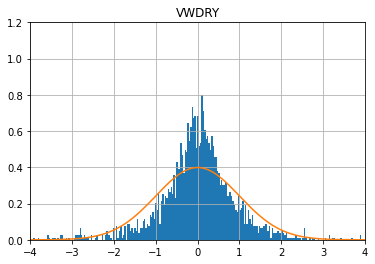

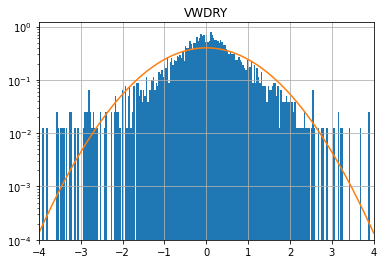

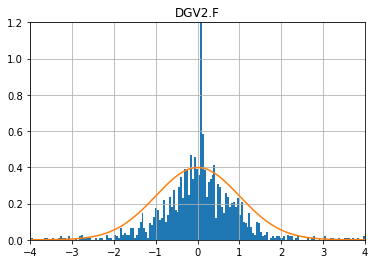

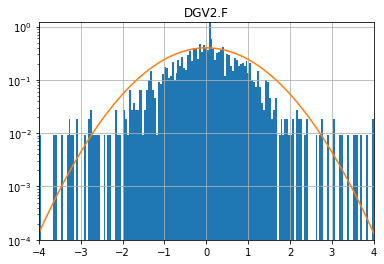

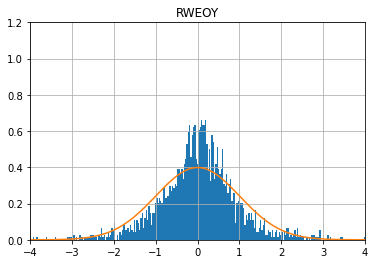

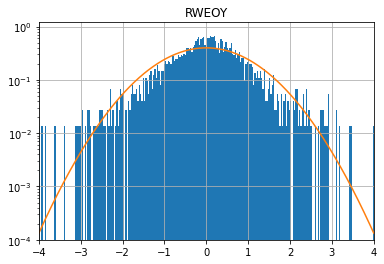

In [19]:
for share in shares:
    R_k.hist(column = share, density = True, bins = 500)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
    plt.axis([-4, 4, 0, 1.2])
    plt.show()

    R_k.hist(column = share, density = True, bins = 500, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
    plt.axis([-4, 4, 1e-4, 1.2])
    plt.show()

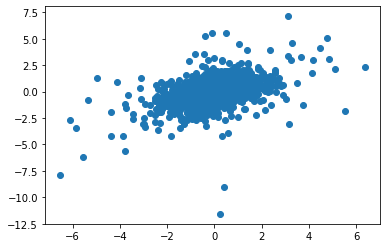

In [20]:
plt.scatter(R_k['PFE'], R_k['AZN'])
plt.show()

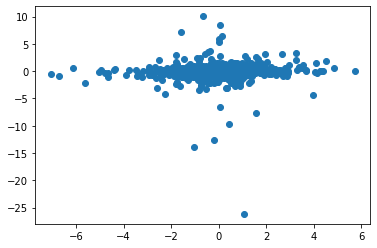

In [21]:
plt.scatter(R_k['TSLA'], R_k['GME'])
plt.show()

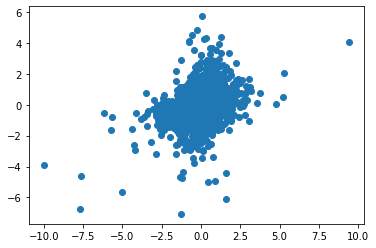

In [22]:
plt.scatter(R_k['DDAIF'], R_k['TSLA'])
plt.show()

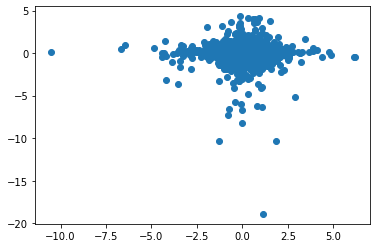

In [23]:
plt.scatter(R_k['VWDRY'], R_k['DGV2.F'])
plt.show()

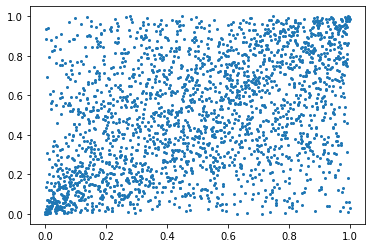

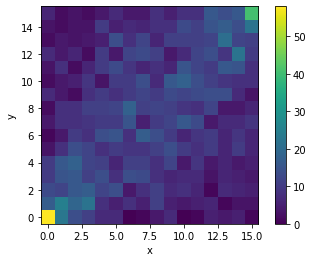

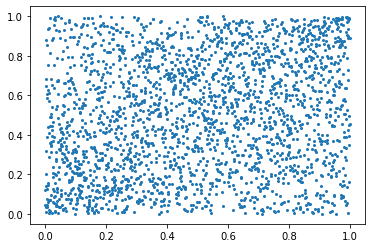

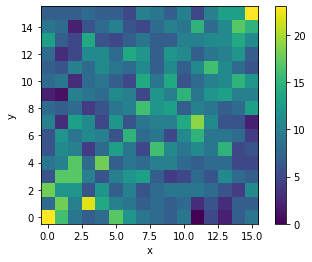

In [37]:
pfe = qrank(R_k['PFE'])
azn = qrank(R_k['AZN'])

plt.scatter(pfe, azn, s = 4)
plt.show()

heatmap, xedges, yedges = np.histogram2d(pfe, azn, bins=(16, 16))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

tesla = qrank(R_k['TSLA'])
gme = qrank(R_k['GME'])

plt.scatter(tesla, gme, s = 4)
plt.show()

heatmap, xedges, yedges = np.histogram2d(tesla, gme, bins=(16, 16))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

Date
2011-02-14    0.872482
2011-02-15   -0.023591
2011-02-16    0.902048
2011-02-17    0.336956
2011-02-18   -0.751407
                ...   
2021-02-05    0.043068
2021-02-08   -0.246429
2021-02-09    0.309241
2021-02-10   -0.537305
2021-02-11   -0.722227
Name: PFE, Length: 2356, dtype: float64


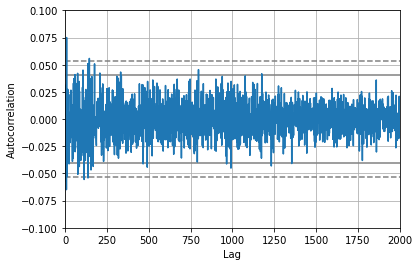

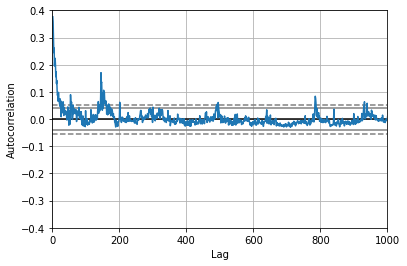

In [99]:
rm = pd.plotting.autocorrelation_plot(R_k['PFE']) 
rm.plot
plt.axis([0, 2000, -0.1, 0.1])
plt.show()

rm2 = pd.plotting.autocorrelation_plot(R_k['PFE'].apply(lambda x: x ** 2)) 
rm2.plot
plt.axis([0, 1000, -0.4, 0.4])
plt.show()

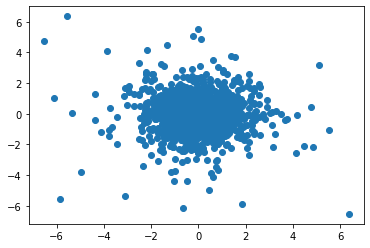

In [47]:
pfe1 = R_k['PFE'][:-1]
pfe2 = R_k['PFE'][1:]

plt.scatter(pfe1, pfe2)
plt.show()

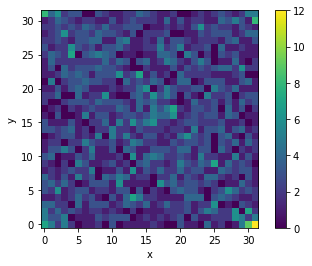

In [49]:
heatmap, xedges, yedges = np.histogram2d(qrank(pfe1), qrank(pfe2), bins=(32, 32))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

3654
3654
3632
3654
3223
3633
3654
3633
3633
3633


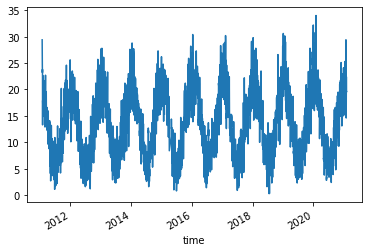

In [116]:
locs = ['Duisburg', 'Kiel', 'Lima', 'Houston', 'Anchorage', 'Buenos Aires', 'St. Petersburg', 'Kapstadt', 'Peking', 'Canberra']
stations = [Stations(lat = 51.43255447541353, lon = 6.800788835979209), Stations(lat = 48.112136726828126, lon = 11.577648262186404)]
stations.append(Stations(lat = -23.624908208702756, lon = -46.46244886533699))
stations.append(Stations(lat = 29.761421774856345, lon = -95.34205538962071))
stations.append(Stations(lat = 61.21248946290539, lon = -149.82838837782495))
stations.append(Stations(lat = -34.73232248271822, lon = -58.367538730538925))
stations.append(Stations(lat = 59.9214352225393, lon = 30.353551450337235))
stations.append(Stations(lat = -33.988416855015124, lon = 18.52598649283691))
stations.append(Stations(lat = 39.884160925245155, lon = 116.39399713290861))
stations.append(Stations(lat = -35.32332511410454, lon = 149.1169978599246))

for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    print(len(city_data))
    if i == 9:
        city_data.plot()
        plt.show()

In [86]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    print(locs[i] + ' Mean: ' + str(city_data.mean()))
    print(locs[i] + ' Var: ' + str(city_data.var()))
    print(locs[i] + ' Skew: ' + str(city_data.skew()))
    print(locs[i] + ' Kurtosis: ' + str(city_data.kurtosis() + 3))

Duisburg Mean: 11.663163656267093
Duisburg Var: 43.379053333734944
Duisburg Skew: 0.03816181128038484
Duisburg Kurtosis: 2.461688348909456
Kiel Mean: 10.665790914066783
Kiel Var: 58.63771800280827
Kiel Skew: -0.05622645528022202
Kiel Kurtosis: 2.2731664379959278
Lima Mean: 20.34474118942727
Lima Var: 11.981823067121484
Lima Skew: -0.2323397855339267
Lima Kurtosis: 2.7812969642213154
Houston Mean: 21.859038089089697
Houston Var: 47.11007811866475
Houston Skew: -0.7174806876082429
Houston Kurtosis: 2.708396696809906
Anchorage Mean: 3.1095873409866575
Anchorage Var: 99.05301482034884
Anchorage Skew: -0.3872889767720152
Anchorage Kurtosis: 2.269838903233234
Buenos Aires Mean: 17.40578034682082
Buenos Aires Var: 35.47785754755416
Buenos Aires Skew: -0.03674742865427825
Buenos Aires Kurtosis: 2.250152090397911
St. Petersburg Mean: 6.635012386457447
St. Petersburg Var: 85.94732555739067
St. Petersburg Skew: -0.26009200210671346
St. Petersburg Kurtosis: 2.612176715967987
Kapstadt Mean: 17.1189

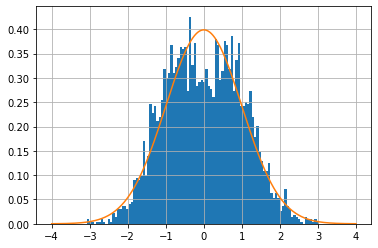

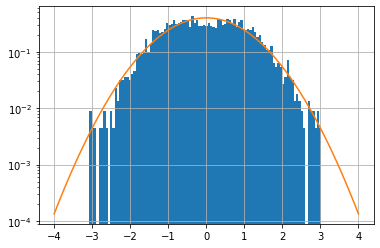

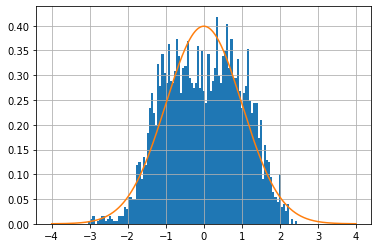

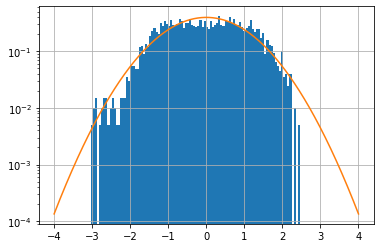

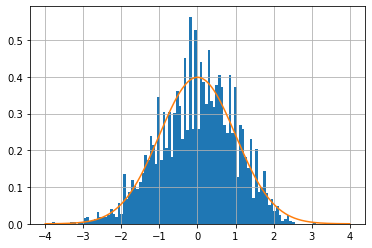

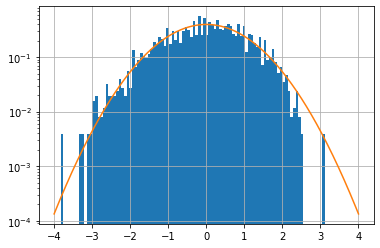

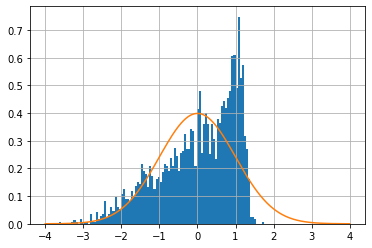

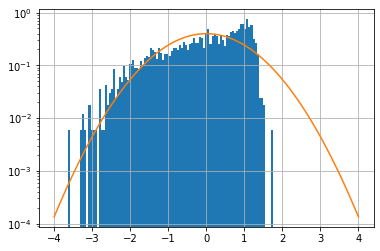

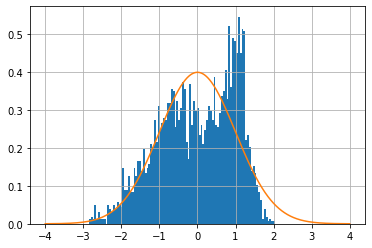

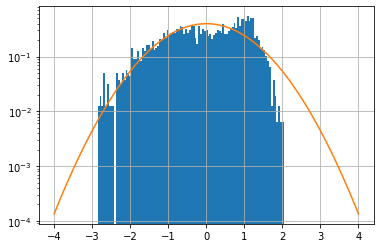

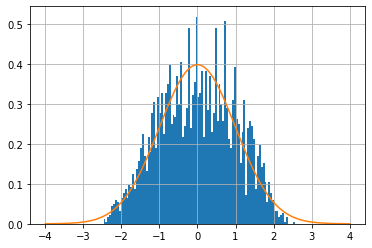

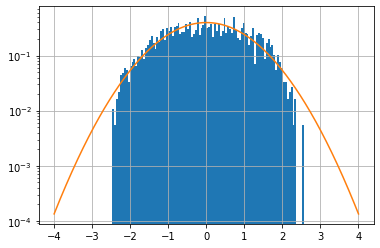

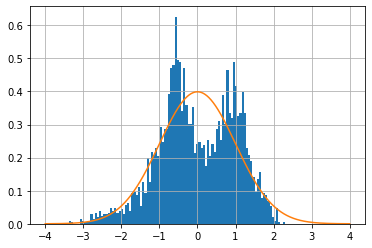

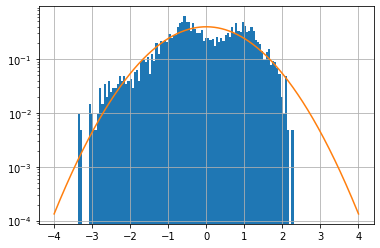

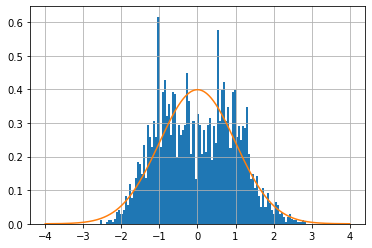

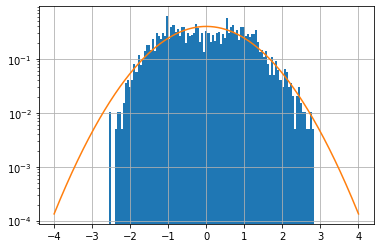

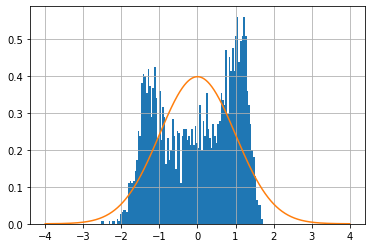

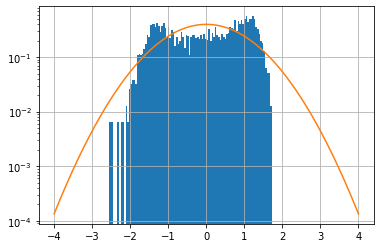

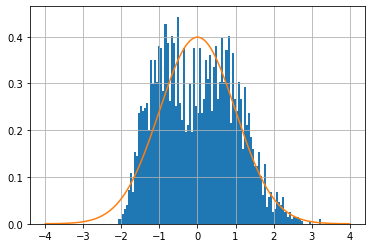

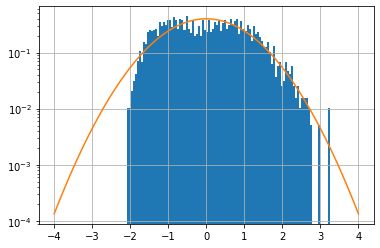

In [87]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    data_n = city_data.sub(city_data.mean()).div(city_data.std())
    data_n.hist(density = True, bins = 100)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
    plt.show()
    
    data_n.hist(density = True, bins = 100, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
    plt.show()

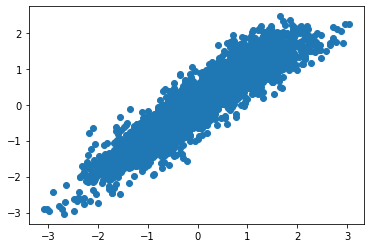

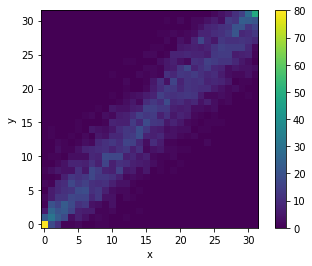

In [90]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())

station2 = stations[1].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
data_n2 = city_data2.sub(city_data2.mean()).div(city_data2.std())

plt.scatter(data_n1, data_n2)
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

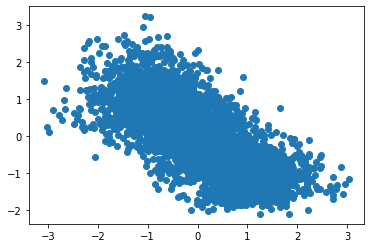

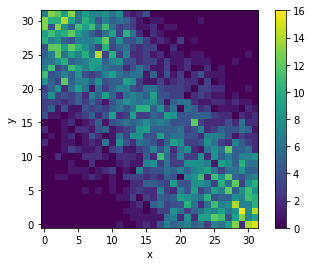

In [93]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())

station2 = stations[9].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
data_n2 = city_data2.sub(city_data2.mean()).div(city_data2.std())

for i in range(len(data_n1) - len(data_n2)):
    c = int(np.random.random() * len(data_n1))
    data_n1 = data_n1.drop(data_n1.index[c])
    
plt.scatter(data_n1, data_n2)
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

time
2011-02-01    0.368385
2011-02-02    0.788106
2011-02-03    1.426083
2011-02-04    0.754528
2011-02-05    0.955995
                ...   
2021-01-28    1.123883
2021-01-29    1.039939
2021-01-30    0.334807
2021-01-31    0.082974
2021-02-01    0.469118
Name: tavg, Length: 3633, dtype: float64


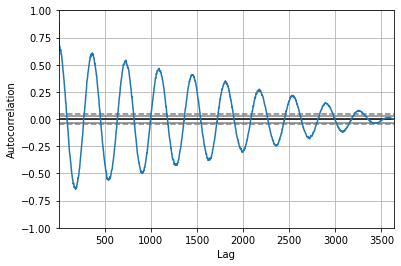

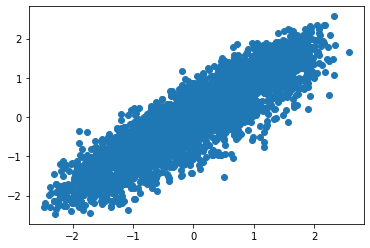

In [107]:
station1 = stations[5].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())
d1 = data_n1[:-1]
d2 = data_n1[1:]

print(data_n1)

d3 = pd.plotting.autocorrelation_plot(data_n1) 
d3.plot
#plt.axis([0, 3000, -0.1, 0.1])
plt.show()

plt.scatter(d1, d2)
plt.show()

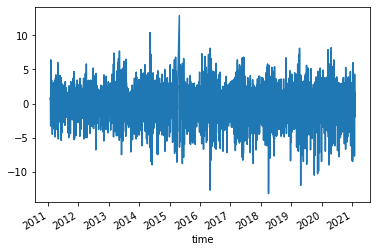

In [112]:
station1 = stations[8].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_dff = city_data1.diff()

data_dff.plot()
plt.show()

In [113]:
for i, st in enumerate(stations):
    station1 = st.fetch(1)
    raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data1 = raw_data1.fetch()
    city_data1 = raw_data1['tavg']
    data_dff = city_data1.diff()

    print(locs[i] + ' Mean: ' + str(data_dff.mean()))
    print(locs[i] + ' Var: ' + str(data_dff.var()))
    print(locs[i] + ' Skew: ' + str(data_dff.skew()))
    print(locs[i] + ' Kurtosis: ' + str(data_dff.kurtosis() + 3))

Duisburg Mean: 0.001532986586367355
Duisburg Var: 4.930517912178297
Duisburg Skew: -0.12040462139541412
Duisburg Kurtosis: 3.5920559452726555
Kiel Mean: 0.0026279770052012054
Kiel Var: 6.098667790640959
Kiel Skew: -0.5271317080450719
Kiel Kurtosis: 4.127859327876566
Lima Mean: 0.00016524373450839882
Lima Var: 4.216898044312342
Lima Skew: -0.777192607854478
Lima Kurtosis: 4.415989830558375
Houston Mean: -0.007758031442241959
Houston Var: 7.957686800918409
Houston Skew: -1.0056971661200165
Houston Kurtosis: 7.561352267359094
Anchorage Mean: -0.004562383612662924
Anchorage Var: 6.962217613461955
Anchorage Skew: 0.028495140828642036
Anchorage Kurtosis: 6.06774380914832
Buenos Aires Mean: 0.0001651982378854605
Buenos Aires Var: 7.978898347805328
Buenos Aires Skew: -0.46326398414585507
Buenos Aires Kurtosis: 3.3436335584180576
St. Petersburg Mean: -0.002065546681355
St. Petersburg Var: 5.614207853553705
St. Petersburg Skew: 0.020356756311479776
St. Petersburg Kurtosis: 4.41177545229955
Kapst

3654
3654


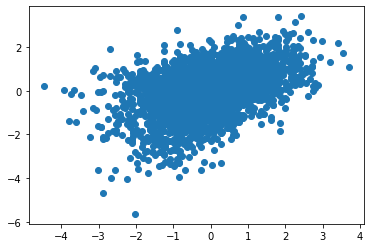

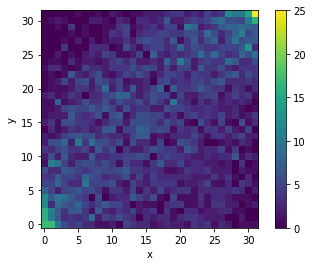

In [118]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())
print(len(data_n1))

station2 = stations[1].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
city_data_ = city_data2.diff()
data_n2 = city_data_.sub(city_data_.mean()).div(city_data_.std())
print(len(data_n2))

plt.scatter(data_n1, data_n2)
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

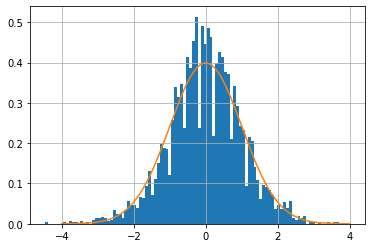

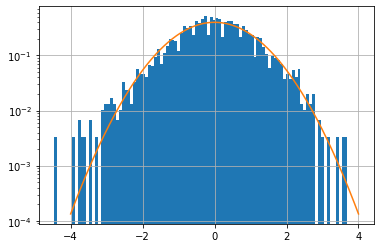

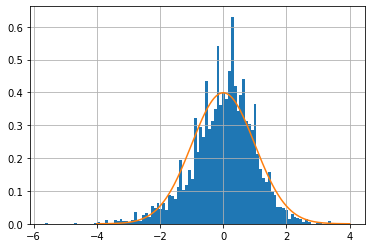

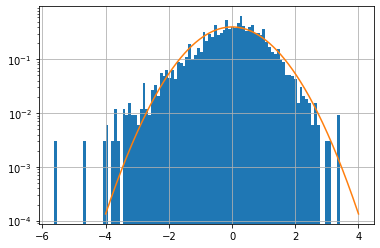

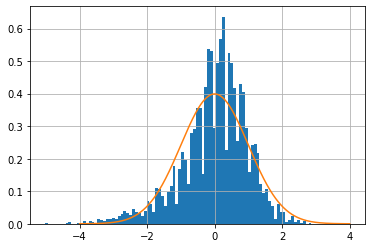

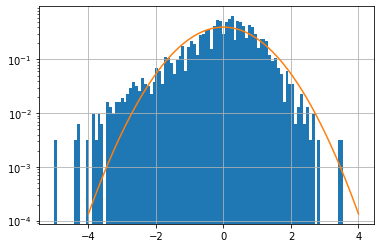

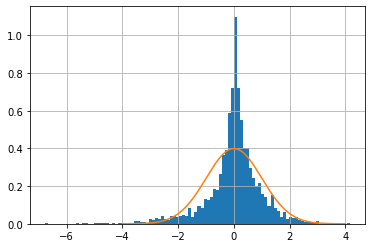

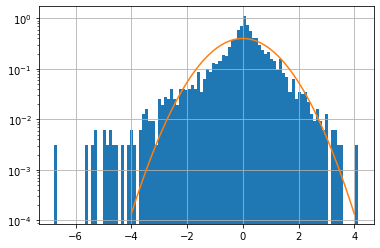

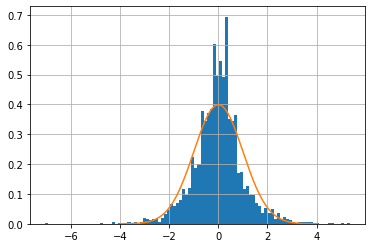

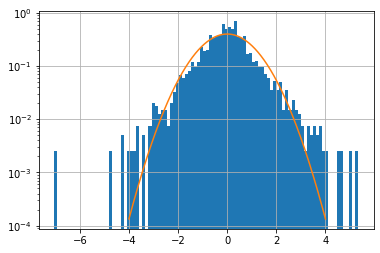

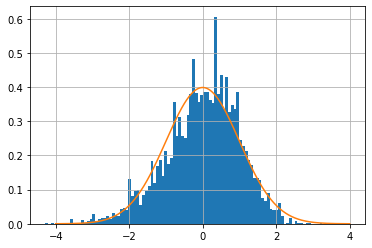

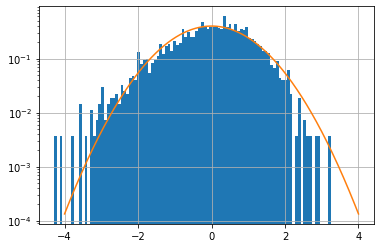

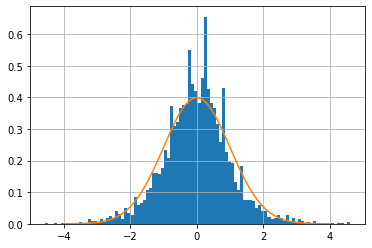

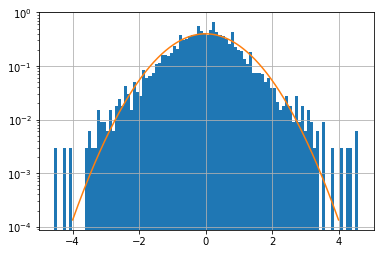

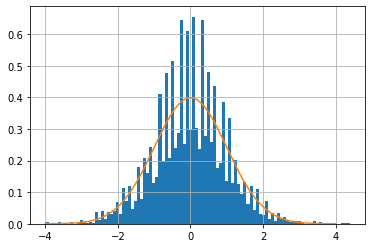

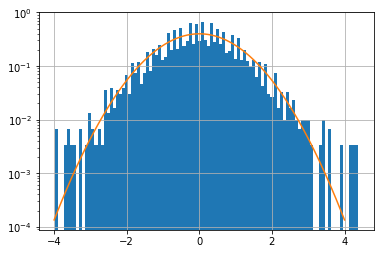

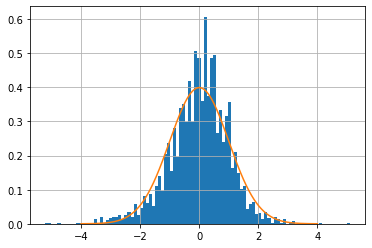

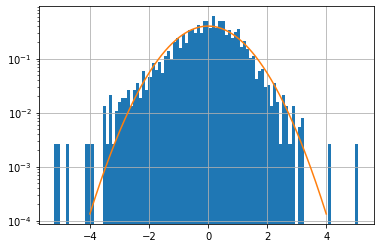

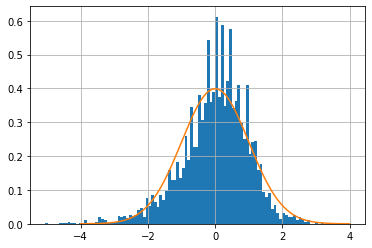

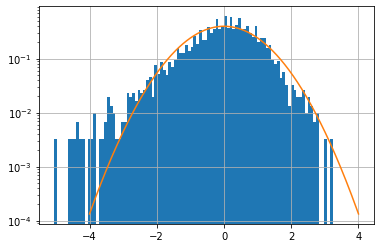

In [119]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    city_data = city_data.diff()
    data_n = city_data.sub(city_data.mean()).div(city_data.std())
    data_n.hist(density = True, bins = 100)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
    plt.show()
    
    data_n.hist(density = True, bins = 100, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)))
    plt.show()

3654
3633


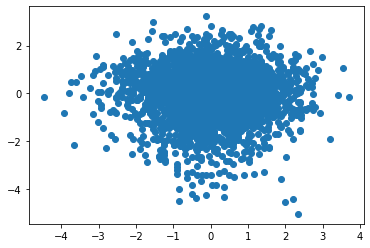

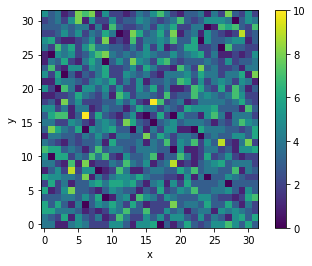

In [120]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())
print(len(data_n1))

station2 = stations[9].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
city_data_ = city_data2.diff()
data_n2 = city_data_.sub(city_data_.mean()).div(city_data_.std())
print(len(data_n2))

for i in range(len(data_n1) - len(data_n2)):
    c = int(np.random.random() * len(data_n1))
    data_n1 = data_n1.drop(data_n1.index[c])

plt.scatter(data_n1, data_n2)
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, origin = 'lower')
plt.colorbar()
plt.show()

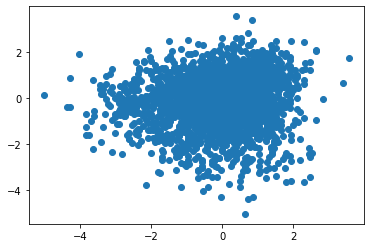

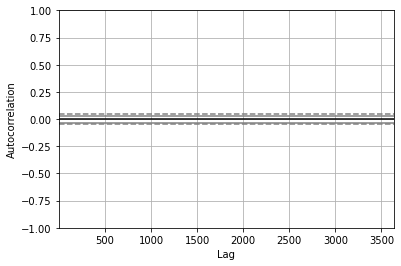

In [135]:
station1 = stations[2].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())

d1 = data_n1[:-1]
d2 = data_n1[1:]

plt.scatter(d1, d2)
plt.show()

d34 = pd.plotting.autocorrelation_plot(data_n1) 
d34.plot
#plt.axis([0, 3000, -0.1, 0.1])
plt.show()